# CCRB Substantiated Claims

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pandas_bokeh
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pandas_bokeh.output_notebook()

from ccrb_utils import *

Loading BokehJS ...

In [3]:
command_list = ["NARCBBX", "WARRSEC",]+ \
               [f"04{i} PCT" for i in range(10)]+ \
               [f"05{k} PCT" for k in [0,2]]   
menu_option = ["Narcotics BX","Warrant Service"]+ \
              [f"4{i} Precinct" for i in range(10)]+ \
              [f"5{k} Precinct" for k in [0,2]]

In [4]:
# Should add these to the clean up file
url = "ccrb_clean"
ccrb_df = pd.read_csv(url, parse_dates=["Incident.Date"])
ccrb_df = ccrb_df.drop(['Unnamed: 0', 'AsOfDate', 'Unique.Id',
                        'First.Name', 'Last.Name'],
                       axis=1)
ccrb_df.columns = ccrb_df.columns.str.replace(".","_")
ccrb_df.rename(columns={"NYPDDisposition":"NYPD_disposition", 
                        "PenaltyDesc":"Penalty", 
                       "ShieldNo":"Shield_No"}, 
              inplace=True)
ccrb_df.columns = ccrb_df.columns.str.lower()
ccrb_df.dropna(subset=['incident_date'], inplace=True)
ccrb_df.incident_date = pd.to_datetime(ccrb_df.incident_date, format='%Y-%m-%d')
ccrb_df = ccrb_df[ccrb_df['incident_date'] > "1984-01-01"]

In [5]:
no_penalty_list = ["no disciplinary action-dup",
                   "no disciplinary action-dismissed",
                   "no disciplinary action-sol", "filed",
                   " retained, without discipline"]
other_list = ["retained, with discipline", " other",
              np.NaN, 0.0]
outcome_list = [np.NaN, "not guilty", 0.0]

ccrb_df.nypd_disposition = ccrb_df.nypd_disposition.apply(lambda x: make_nypd_bins(x,
                                    no_penalty_list,
                                    other_list))
ccrb_df.penalty = ccrb_df.penalty.apply(lambda x: make_penalty_bins(x,
                                       outcome_list))
ccrb_df.penalty = ccrb_df.penalty.apply(lambda x: make_condensed_penalty(x))
ccrb_df.penalty = ccrb_df.penalty.apply(lambda x: fix_instructions(x))

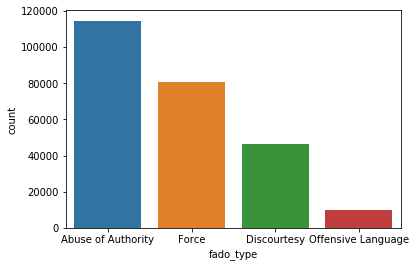

In [6]:
sns.countplot(data=ccrb_df, x="fado_type",
             order=ccrb_df.fado_type.value_counts().index)

In [7]:
plot_order = ccrb_df.board_disposition.value_counts()
plot_order.index

Index(['unsubstantiated', 'exonerated', 'complainant uncooperative',
       'unfounded', 'substantiated', 'complaint withdrawn',
       'complainant unavailable', 'alleged victim uncooperative',
       'alleged victim unavailable', 'closed - pending litigation',
       'subject retired', 'subject resigned', 'miscellaneous',
       'victim unidentified', 'officer(s) unidentified', 'subject terminated',
       'witness uncooperative', 'witness unavailable'],
      dtype='object')

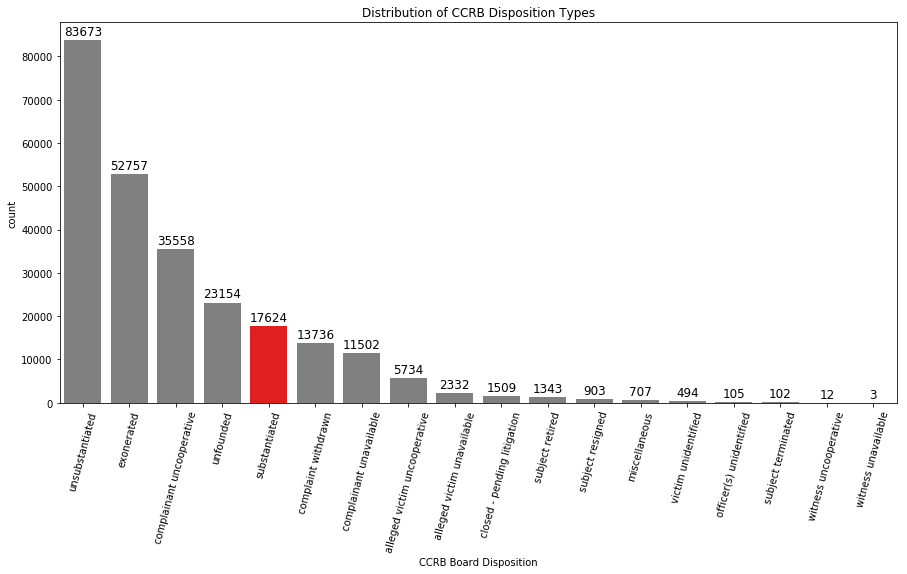

In [8]:
plot_order = ccrb_df.board_disposition.value_counts()
plt.figure(figsize=(15,7))
colors = ['grey' if x != 'substantiated' else 'red' for x in plot_order.index]
ax = sns.countplot(data=ccrb_df, x='board_disposition', 
                  order= plot_order.index, 
                  palette=colors) 
plt.title("Distribution of CCRB Disposition Types")
make_bar_annotation(ax=ax, int=True)
plt.xticks(rotation=75)
plt.xlabel("CCRB Board Disposition")
plt.show()

In [9]:
ccrb_substan = ccrb_df[ccrb_df.board_disposition == 'substantiated']
plot_order_1 = ccrb_substan.nypd_disposition.value_counts()
#plot_order_2 = ccrb_substan.penalty.unique().tolist()
nypd_dis_top = ccrb_substan.nypd_disposition.unique().tolist()

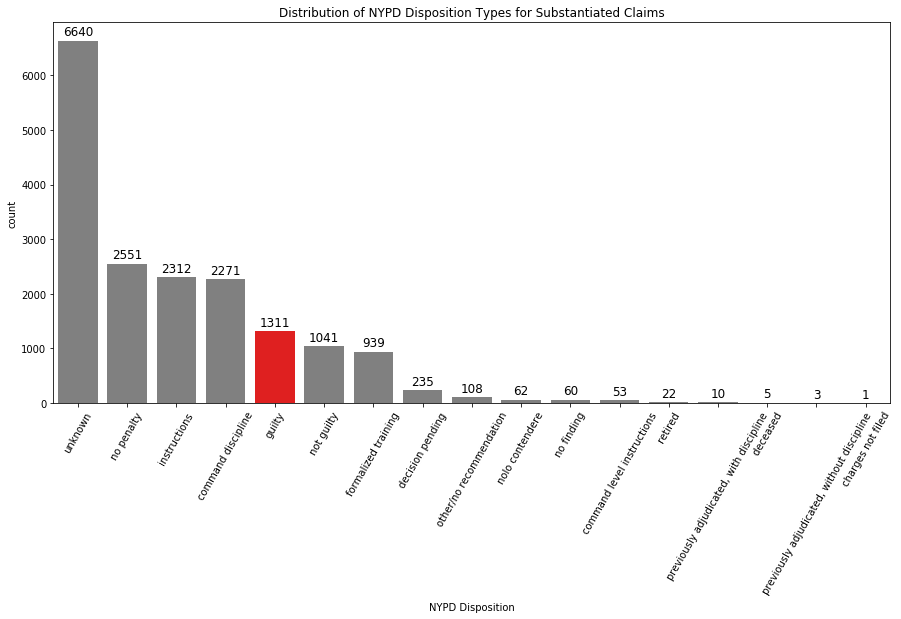

In [10]:
# pal_1 = []
# for k, v, in enumerate(plot_order_1):
#     if v in ["instructions", "command discipline"]:
#         k='lightblue'
#     elif v == 'guilty':
#         k = 'red'
#     else: k='grey'
#     pal_1.append(k)
plt.figure(figsize=(15,7))
ax = sns.countplot(data=ccrb_substan,
                   x='nypd_disposition', 
                   order= plot_order_1.index, 
                   palette=['grey' if x != 'guilty' else 'red' for x in plot_order_1.index])
make_bar_annotation(ax, int=True)
plt.title("Distribution of NYPD Disposition Types for Substantiated Claims")
plt.xticks(rotation=60)
plt.xlabel("NYPD Disposition")
plt.show()

In [24]:
corr_prep = ccrb_substan[["full_name","nypd_disposition", "penalty", "rank"]]

In [60]:
nypd_name = corr_prep[["full_name", "nypd_disposition", "rank"]] \
            .groupby(["full_name","nypd_disposition"]) \
            .count()["rank"].reset_index()
penalty_name = corr_prep[["full_name", "penalty", "rank"]] \
            .groupby(["full_name","penalty"]) \
            .count()["rank"].reset_index()
test = pd.merge(nypd_name, penalty_name,how="inner")
test = test[["nypd_disposition","penalty"]]

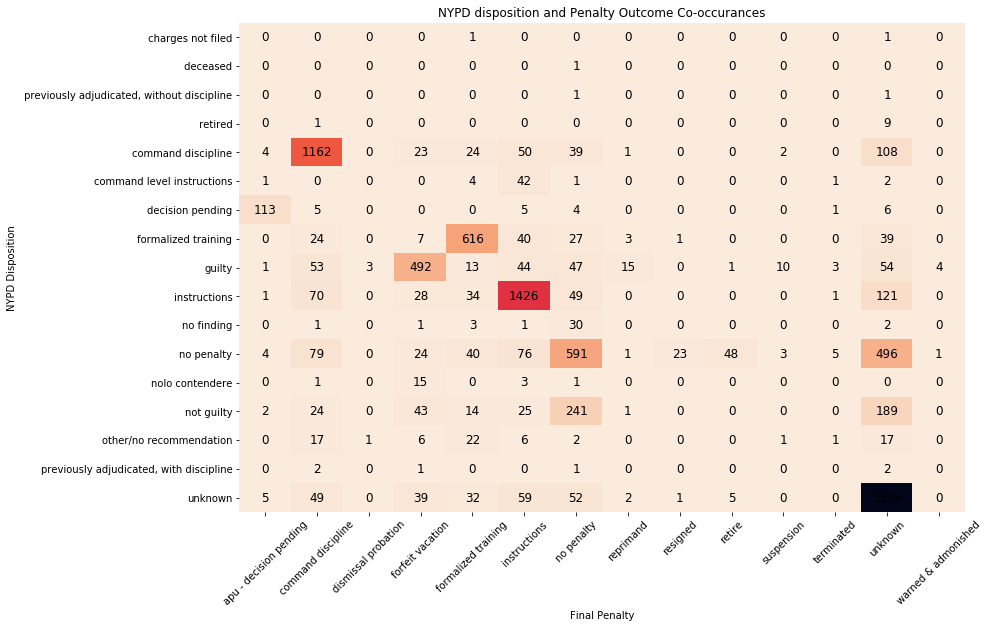

In [61]:
tab_test = pd.crosstab(test.nypd_disposition, test.penalty)
font_dict = {"color":"black", "size":"12"}
plt.figure(figsize=(13,9))
sns.heatmap(tab_test, 
            cmap="rocket_r",
            annot=True,
            fmt=".0f",
            annot_kws=font_dict,
            cbar=False)
plt.xticks(rotation=45)
plt.title("NYPD disposition and Penalty Outcome Co-occurances")
plt.ylabel("NYPD Disposition")
plt.xlabel("Final Penalty")
plt.show()

In [62]:
# font_dict = {"color":"black", "size":"12"}
# plt.figure(figsize=(13,9))
# x_tab = pd.crosstab(corr_prep.nypd_disposition, corr_prep.penalty)
# sns.heatmap(x_tab, 
#             cmap="rocket_r",
#             annot=True,
#             fmt=".0f",
#             annot_kws=font_dict,
#             cbar=False)
# plt.xticks(rotation=45)
# plt.title("NYPD disposition and Penalty Outcome Co-occurances")
# plt.ylabel("NYPD Disposition")
# plt.xlabel("Final Penalty")
# plt.show()

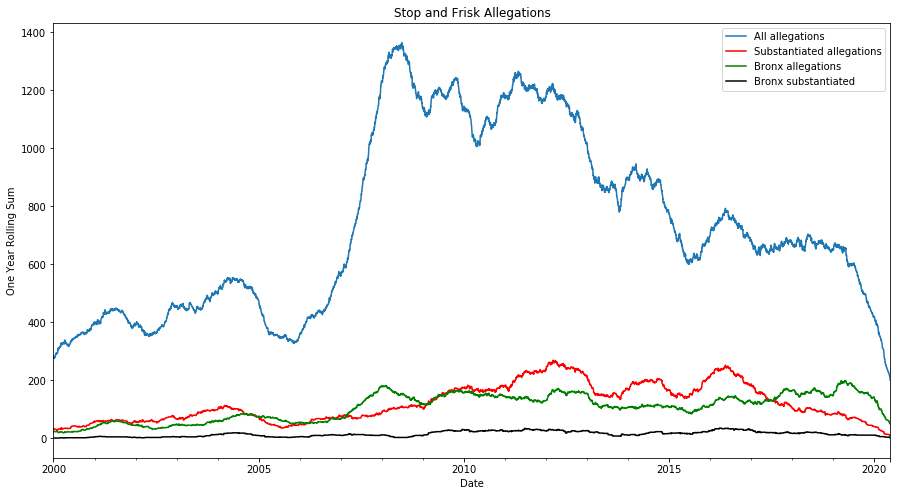

In [93]:
pd.options.display.max_rows = 100
stop_frisk_ser = ccrb_df[
        (ccrb_df.allegation != "vehicle stop") &
        (ccrb_df.allegation.str.contains("stop|frisk"))] \
        [["incident_date", "allegation"]] \
        .groupby("incident_date").count()["allegation"] \
        .reset_index()
stop_frisk_substan = ccrb_df[
        (ccrb_df.board_disposition == "substantiated") &
        (ccrb_df.allegation != "vehicle stop") &
        (ccrb_df.allegation.str.contains("stop|frisk"))] \
        [["incident_date", "allegation"]] \
        .groupby("incident_date").count()["allegation"] \
        .reset_index()
stop_frisk_BX = ccrb_df[
        (ccrb_df.command.isin(command_list)) &
        (ccrb_df.allegation.str.contains("stop|frisk"))] \
        [["incident_date", "allegation"]] \
        .groupby("incident_date").count()["allegation"] \
        .reset_index()
stop_frisk_bx_sub = ccrb_df[
        (ccrb_df.board_disposition == "substantiated") &
        (ccrb_df.command.isin(command_list)) &
        (ccrb_df.allegation.str.contains("stop|frisk"))] \
        [["incident_date", "allegation"]] \
        .groupby("incident_date").count()["allegation"] \
        .reset_index()
start_date = ccrb_df.incident_date.min()
end_date = ccrb_df.incident_date.max()

idx = pd.date_range(start=start_date, 
                   end=end_date)
rolling_df_substan = make_rolling_sum(stop_frisk_substan, idx, drop_command=False)
rolling_df = make_rolling_sum(stop_frisk_ser, idx, drop_command=False)
rolling_df_bx = make_rolling_sum(stop_frisk_BX, idx, drop_command=False)
rolling_df_bx_sub = make_rolling_sum(stop_frisk_bx_sub, idx, drop_command=False)

rolling_df = rolling_df[rolling_df.Date >= "2000-01-01"]
rolling_df_substan = rolling_df_substan[rolling_df_substan.Date >= "2000-01-01"]
rolling_df_bx = rolling_df_bx[rolling_df_bx.Date >= "2000-01-01"]
rolling_df_bx_sub = rolling_df_bx_sub[rolling_df_bx_sub.Date >= "2000-01-01"]


ax = rolling_df.plot(x='Date',
                     y="allegation", 
                     figsize=(15,8),
                     legend=False,
                    title="Stop and Frisk Allegations")
rolling_df_substan.plot(x='Date',
                        y="allegation",
                        color="red",
                        ax=ax,
                        legend=False)
rolling_df_bx.plot(x='Date',
                        y="allegation",
                        color="green",
                        ax=ax,
                        legend=False)
rolling_df_bx_sub.plot(x='Date',
                        y="allegation",
                        color="black",
                        ax=ax,
                        legend=False)
ax.legend(["All allegations", "Substantiated allegations", "Bronx allegations", "Bronx substantiated"])
plt.ylabel("One Year Rolling Sum")
plt.show()

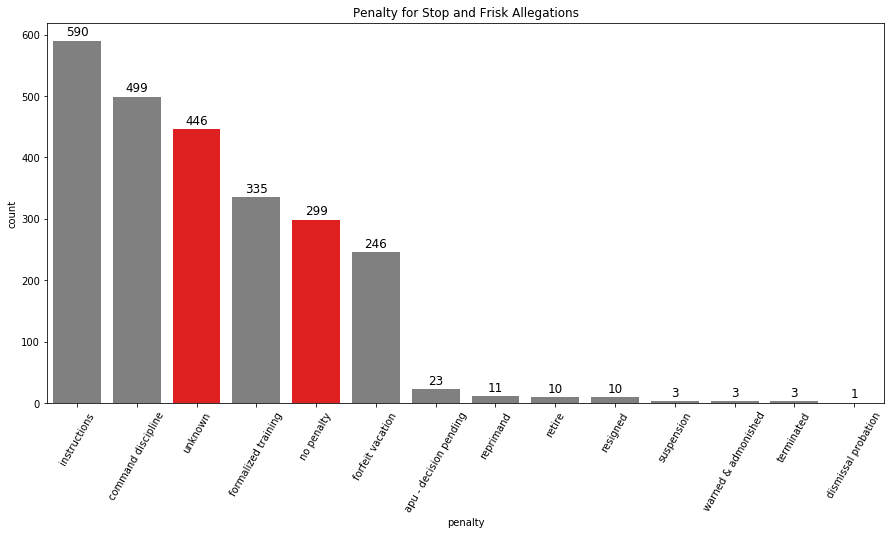

In [94]:
s_f_penalty = ccrb_df[
        (ccrb_df.board_disposition == "substantiated") &
        (ccrb_df.allegation != "vehicle stop") &
        (ccrb_df.allegation.str.contains("stop|frisk"))]
plot_order = s_f_penalty.penalty.value_counts()
plt.figure(figsize=(15,7))
ax = sns.countplot(data=s_f_penalty,
              x="penalty",
             order=plot_order.index,
             palette=["red" if  x=="no penalty" 
                      or x=="unknown" else "grey" 
                      for x in plot_order.index])
make_bar_annotation(ax, int=True)
plt.title("Penalty for Stop and Frisk Allegations")
plt.xticks(rotation=60)
plt.show()

In [95]:
breath_df = ccrb_df[
        (ccrb_df.command.isin(ccrb_df.command.unique())) &
        (ccrb_df.allegation.str.contains("choke|restrict"))] \
        [["incident_date", "allegation"]] \
        .groupby("incident_date").count()["allegation"] \
        .reset_index()
restrain_df_substan = ccrb_df[
        (ccrb_df.board_disposition == "substantiated") &
        (ccrb_df.allegation.str.contains("restrict|choke"))] \
        [["incident_date", "allegation"]] \
        .groupby("incident_date").count()["allegation"] \
        .reset_index()

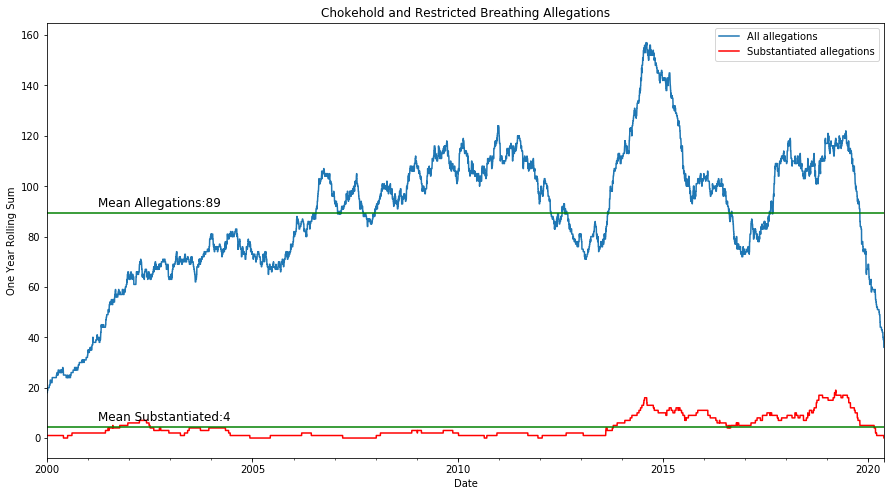

In [96]:
rolling_df_substan = make_rolling_sum(restrain_df_substan, idx, drop_command=False)
rolling_df = make_rolling_sum(breath_df, idx, drop_command=False)
rolling_df = rolling_df[rolling_df.Date >= "2000-01-01"]
rolling_df_substan = rolling_df_substan[rolling_df_substan.Date >= "2000-01-01"]
ax = rolling_df.plot(x='Date',
                     y="allegation", 
                     figsize=(15,8),
                     legend=False,
                     title="Chokehold and Restricted Breathing Allegations")
rolling_df_substan.plot(x='Date',
                        y="allegation",
                        color="red",
                        ax=ax,
                        legend=False)
ax.legend(["All allegations", "Substantiated allegations"])
ax.axhline(y=round(rolling_df.allegation.mean(),2), color="green")
ax.axhline(y=round(rolling_df_substan.allegation.mean(),2), color = "green")
make_annots(ax, annot_labels=["Mean Allegations", "Mean Substantiated"],
            annot_values=[rolling_df.allegation.mean(), rolling_df_substan.allegation.mean()],
            annot_x_value="2001-01-01",
            int=True)
plt.ylabel("One Year Rolling Sum")
plt.show()

chokeholds were banned for use by NYPD in 1993. Eric Garner Law signed 6/2020. 89 substantiated CCRB reports filed for chokehold or restricted breathing from 01-01-2020. Under the new discipline matrix all of these substantiated _should_ result in the officer being removed (forced resignation or termination) from the NYPD. 

In [97]:
cop_df = ccrb_df[(ccrb_df.allegation.str.contains("choke|restrict")) &
       (ccrb_df.board_disposition == 'substantiated')]

In [98]:
#cop_df.penalty = cop_df.penalty.astype(str)
# cop_df.penalty = cop_df.penalty.apply(lambda x: make_condensed_penalty(x))

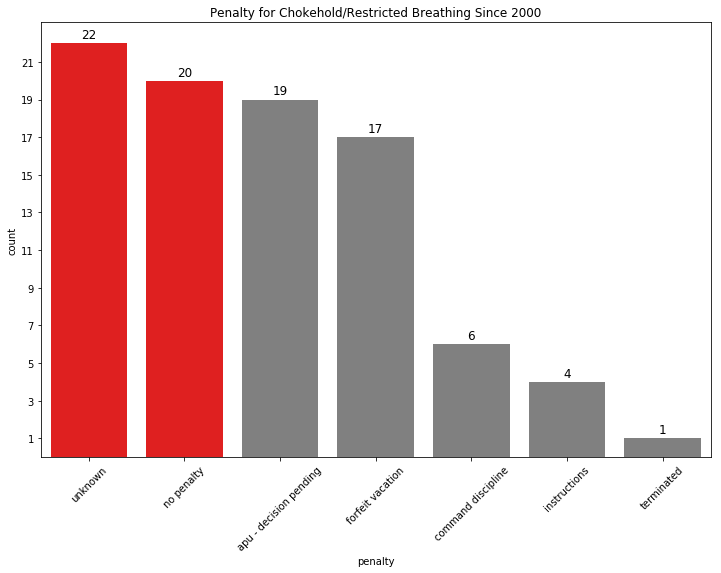

In [99]:
plt.figure(figsize=(12,8))
ax = sns.countplot(data=cop_df, x="penalty",
             order=cop_df.penalty.value_counts().index,
             palette=["red" if x=="no penalty" or x=="unknown" 
                      else "grey" for x in cop_df.penalty.value_counts().index])
plt.xticks(rotation=45)
y_range = cop_df.penalty.value_counts()
yint = range(min(y_range), (max(y_range)+1), 2)
make_bar_annotation(ax=ax, int=True)
plt.yticks(yint)
plt.title("Penalty for Chokehold/Restricted Breathing Since 2000")
plt.show()

In [100]:
cop_search = cop_df.groupby(["full_name", "shield_no"]).count()["rank"].sort_values(ascending=False)[:20]
# cop_search

In [101]:
# def strip_sexual_harass(row):
#     if "sexually harass - " in row:
#         return row.lstrip("$sexually harass^").strip("-")
#     else: return row

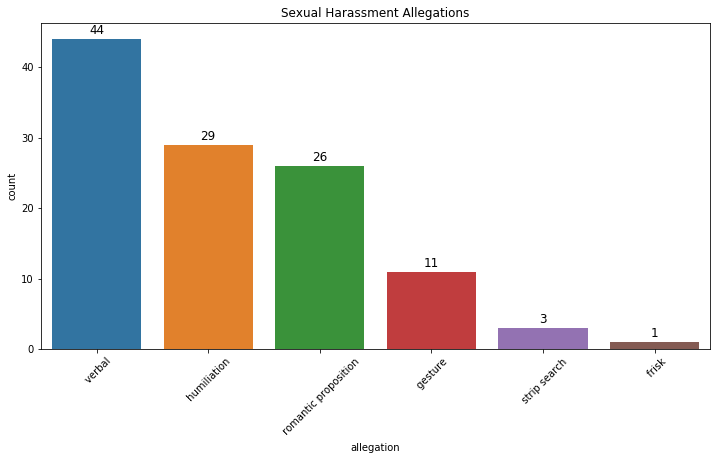

In [102]:
sx_har_df = ccrb_df[(ccrb_df.fado_type.isin(["Abuse of Authority", "Force"])) &
        (ccrb_df.allegation.str.contains("sex|sx"))].reset_index()
sx_har_df.allegation = sx_har_df.allegation.apply(lambda x: strip_sexual_harass(x))

sx_har_df1 = ccrb_df[(ccrb_df.board_disposition == "substantiated") &
                    (ccrb_df.fado_type.isin(["Abuse of Authority", "Force"])) &
                    (ccrb_df.allegation.str.contains("sex|sx"))].reset_index()
sx_har_df1.allegation = sx_har_df1.allegation.apply(lambda x: strip_sexual_harass(x))



plt.figure(figsize=(12,6))

ax = sns.countplot(data=sx_har_df,x="allegation", 
             order=sx_har_df.allegation.value_counts().index)
make_bar_annotation(ax, int=True)


plt.title("Sexual Harassment Allegations")
plt.xticks(rotation=45)
plt.show()

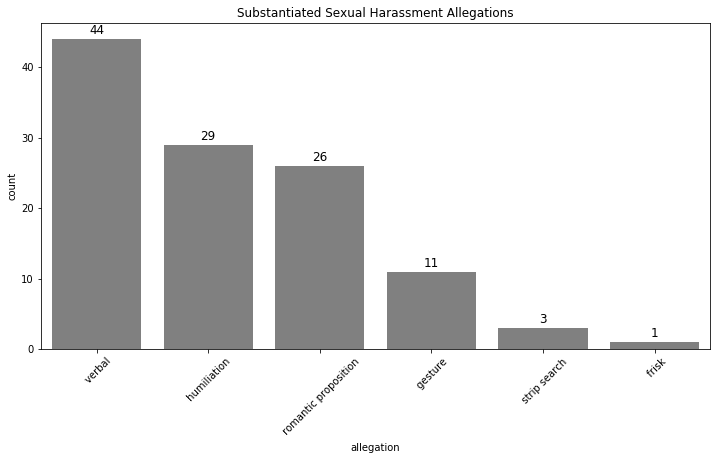

In [134]:
plt.figure(figsize=(12,6))
order_plot = sx_har_df.allegation.value_counts()
ax1 = sns.countplot(data=sx_har_df,x="allegation", 
             order=order_plot.index,
                   palette=['grey' for x in order_plot.index])
make_bar_annotation(ax1, int=True)
plt.title("Substantiated Sexual Harassment Allegations")
plt.xticks(rotation=45)
plt.show()

In [104]:
# plt.figure(figsize=(12,6))
# ax = sns.countplot(data=sx_har_df,x="nypd_disposition", 
#              order=sx_har_df.nypd_disposition.value_counts().index)
# make_bar_annotation(ax, int=True)
# plt.title("Substantiated Sexual Harassment Allegations - NYPD Disposition")
# plt.xticks(rotation=45)
# plt.show()

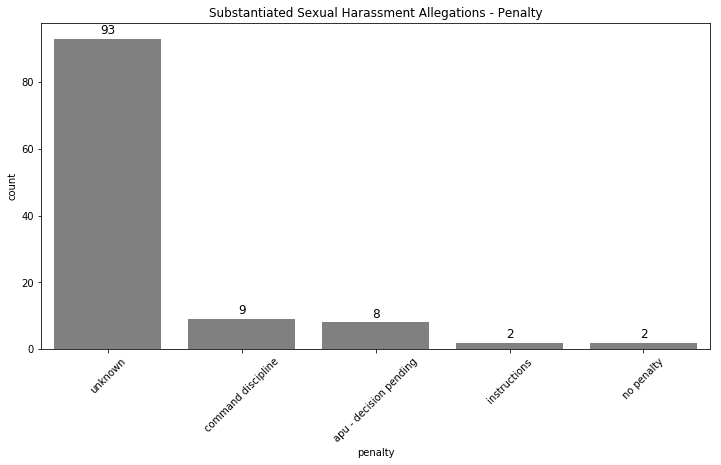

In [136]:
plt.figure(figsize=(12,6))
ax = sns.countplot(data=sx_har_df,x="penalty", 
             order=sx_har_df.penalty.value_counts().index,
                  palette=['grey' for x in sx_har_df.penalty.value_counts().index])
make_bar_annotation(ax, int=True)
plt.title("Substantiated Sexual Harassment Allegations - Penalty")
plt.xticks(rotation=45)
plt.show()

## Who has been terminated?

like, actually terminated.

In [106]:
print(ccrb_df[ccrb_df.penalty == "terminated"].groupby("full_name").count()["rank"].shape[0],
      "police officers have been terminated out of all CCRB complaints filed since",
      ccrb_df.incident_date.min().date(), ".", "Which is",
      round((ccrb_df[ccrb_df.penalty == "terminated"].shape[0]/ccrb_df.shape[0])*100,3),"%.")

12 police officers have been terminated out of all CCRB complaints filed since 1984-01-29 . Which is 0.014 %.


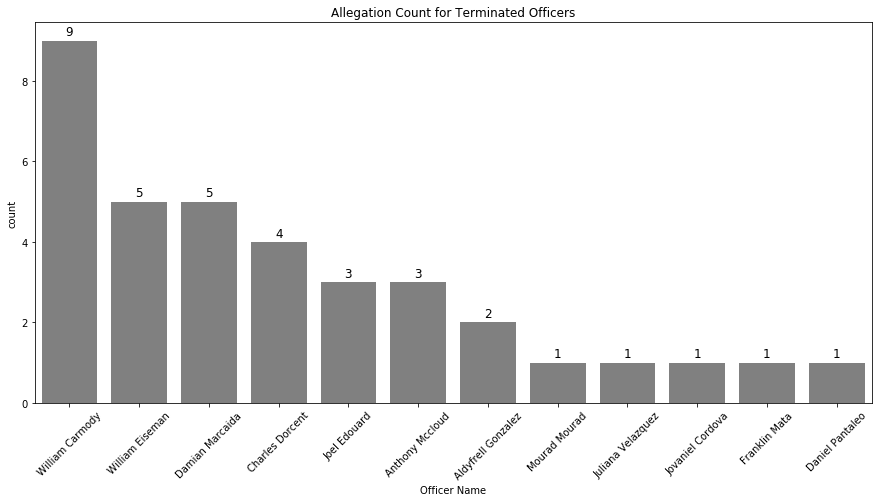

In [153]:
plot = ccrb_df[ccrb_df.penalty == "terminated"] \
                .groupby("full_name") \
                .count()["rank"] \
                .sort_values(ascending=False) \
                .reset_index() \
                .rename(columns={"rank":"count"})
plt.figure(figsize=(15,7))
ax =sns.barplot(data=plot,
             x="full_name",
                y="count",
             #order=plot_order.index,
             palette=['grey' for x in plot.full_name.value_counts().index])
make_bar_annotation(ax, int=True)
plt.title("Allegation Count for Terminated Officers")
plt.xticks(rotation=45)
plt.xlabel("Officer Name")
plt.show()

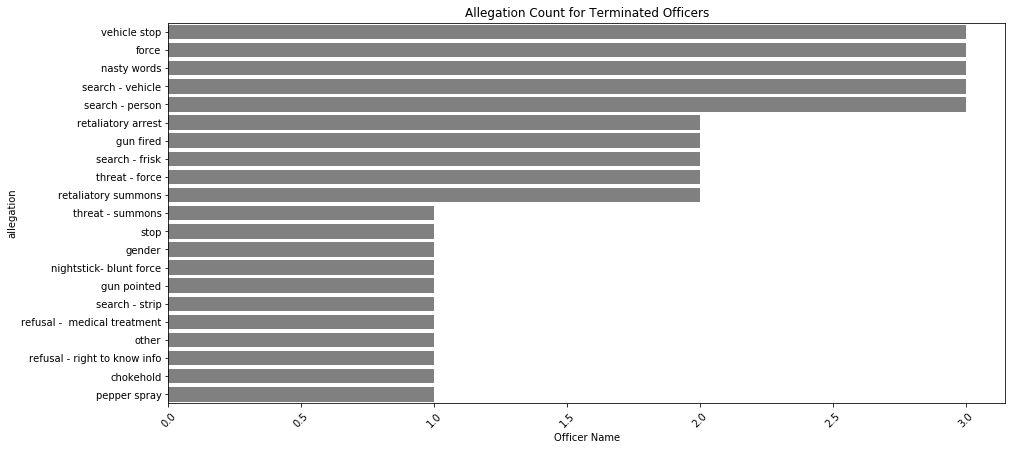

In [152]:
plot = ccrb_df[ccrb_df.penalty == "terminated"]
plot_order = plot.allegation.value_counts()
plt.figure(figsize=(15,7))
ax =sns.countplot(data=plot,
             y="allegation",
             order=plot_order.index,
             palette=["grey" for x in plot_order.index])
# make_bar_annotation(ax, int=True)

plt.title("Allegation Count for Terminated Officers")
plt.xticks(rotation=45)
plt.xlabel("Officer Name")
plt.show()

In [133]:
ccrb_df[ccrb_df.penalty == "terminated"] \
                .groupby(["full_name", "allegation"]) \
                .count()["rank"] \
                .reset_index()

,full_name,allegation,rank
0,Aldyfrell Gonzalez,nasty words,1
1,Aldyfrell Gonzalez,threat - summons,1
2,Anthony Mccloud,search - person,1
3,Anthony Mccloud,stop,1
4,Anthony Mccloud,threat - force,1
5,Charles Dorcent,force,1
6,Charles Dorcent,nasty words,1
7,Charles Dorcent,retaliatory arrest,1
8,Charles Dorcent,search - frisk,1
9,Damian Marcaida,force,1


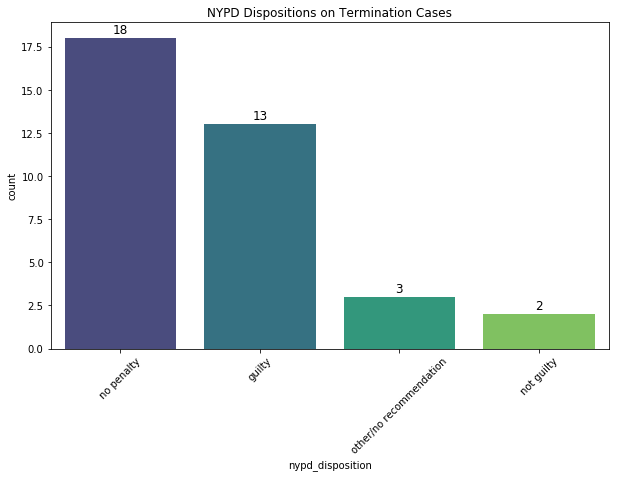

In [26]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=ccrb_df[ccrb_df.penalty == "terminated"],
             x="nypd_disposition",
             order=ccrb_df[ccrb_df.penalty == "terminated"].nypd_disposition.value_counts().index,
             palette="viridis")
plt.title("NYPD Dispositions on Termination Cases")
make_bar_annotation(ax, int=True)
plt.xticks(rotation=45)
plt.show()